#  Venture Creed - Customer Segmentation Analysis
*Creating data-driven customer clusters for targeted marketing strategies*

**Business Objective:**  Venture Creed wants to segment customers based on behavioral traits (revenue, churn, etc.) to:
- Target loyal customers for loyalty programs
- Identify high-potential growth accounts
- Reduce churn with reactivation campaigns

## 🛠️ Setup & Configuration
First, let's import necessary libraries and configure our environment:

In [190]:
# Core data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Appling standard style
sns.set_theme(style='darkgrid') 

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Statistics
from scipy import stats
from scipy.stats import skew
from scipy.stats import zscore


# Standard Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
sns.set_palette('viridis')


## 📂 Data Loading
Let's examine our customer dataset: 

##### Load the Feather file using pyarrow
df = pd.read_feather("Clustering_Data.ftr")
##### Save it as an Excel file
df.to_excel("Dataset files.xlsx", index=False)

In [191]:
# Load dataset
print("Loading customer data...")

df = pd.read_excel('Dataset files.xlsx', sheet_name='output_file')

print(f"\nDataset shape: {df.shape}")
print("\nFirst look at the data:")
df.head(3)

Loading customer data...

Dataset shape: (3030, 18)

First look at the data:


,Customer_ID,Street,City,State_Code,Postal_Code,Country,Seasonality_Segment,EA_Segment,Revenue_Bucket,Profit_Bucket,Market_Share_Segment,Casino_Size_Segment,Market_Potential_Segment,Churn_Segment,Competitiveness_Flag,Volume_Segment,Density_Segment,Propensity
0,Accoount 1,2295 BATTLEFORD RD,MISSISSAUGA,ON,L5N 2W8,CAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,High,High,-
1,Accoount 2,64 WESTBANK EXPY STE A,GRETNA,LA,70053,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Medium,Medium,-
2,Accoount 3,209-229 E Airline Hwy.,LaPlace,LA,70068,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Medium,Medium,-


## 🔍 Data Quality Assessment
Before analysis, we need to check for data issues:

### Missing Values Analysis

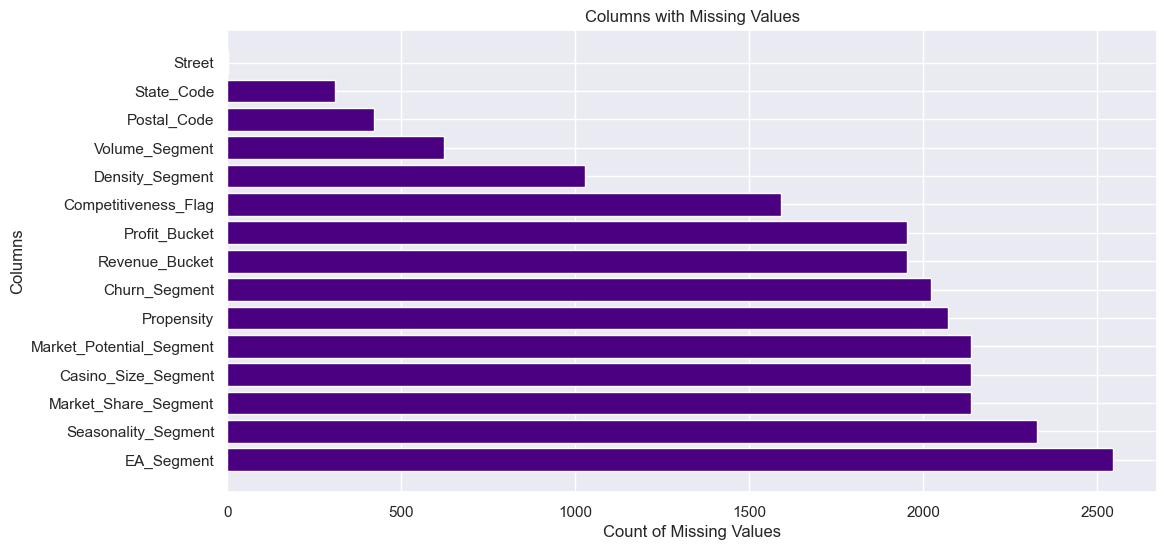

In [192]:
# Replacing placeholders like 'None', '-', '', ' ' with NaN
df.replace(['None', '-', '', ' '], np.nan, inplace=True)

# Visualize missing values
missing = df.isnull().sum()[df.isnull().sum() > 0]

if len(missing) > 0:
    missing = missing.sort_values(ascending=False)
    plt.figure(figsize=(12,6))
    plt.barh(missing.index, missing.values, color='indigo')
    plt.title('Columns with Missing Values')
    plt.xlabel('Count of Missing Values')
    plt.ylabel('Columns')
    plt.show()
else:
    print("No missing values found")


## 🧹 Data Cleaning
We'll perform these cleaning steps:
1. Remove non-behavioral columns
2. Handle missing values appropriately
3. Fix data types

In [193]:
# Removing geographical identifiers (not useful for behavioral clustering)
cols_to_drop = ['Street', 'City', 'State_Code', 'Postal_Code', 'Country']
df_clean = df.drop(columns=cols_to_drop)

print(f"Columns remaining: {list(df_clean.columns)}")

Columns remaining: ['Customer_ID', 'Seasonality_Segment', 'EA_Segment', 'Revenue_Bucket', 'Profit_Bucket', 'Market_Share_Segment', 'Casino_Size_Segment', 'Market_Potential_Segment', 'Churn_Segment', 'Competitiveness_Flag', 'Volume_Segment', 'Density_Segment', 'Propensity']


### Handling Missing Values

In [194]:
# Custom imputation strategy

# For numerical features → use median
num_cols = df_clean.select_dtypes(include='number').columns
df_clean[num_cols] = df_clean[num_cols].apply(lambda x: x.fillna(x.median()))

# For categorical features → use 'Unknown' as a new category
cat_cols = df_clean.select_dtypes(include='object').columns
df_clean[cat_cols] = df_clean[cat_cols].fillna('Unknown')

print("Missing values handled")
df_clean.isnull().sum().sum()


Missing values handled


np.int64(0)

## ⚙️ Feature Preparation
Preparing features for clustering algorithm:

### Encoding Categorical Variables

In [195]:
from sklearn.preprocessing import OrdinalEncoder

# Identify categorical columns
cat_cols = df_clean.select_dtypes(include='object').columns.drop('Customer_ID')

# Label encoding for ordinal categories
le = OrdinalEncoder()

for col in cat_cols:
    df_clean[col] = le.fit_transform(df_clean[[col]].astype(str))

print("Example of encoded data:")
df_clean.head(3)


Example of encoded data:


,Customer_ID,Seasonality_Segment,EA_Segment,Revenue_Bucket,Profit_Bucket,Market_Share_Segment,Casino_Size_Segment,Market_Potential_Segment,Churn_Segment,Competitiveness_Flag,Volume_Segment,Density_Segment,Propensity
0,Accoount 1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,3.0
1,Accoount 2,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,2.0,2.0,3.0
2,Accoount 3,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,2.0,2.0,3.0


## Correlation Matrix 

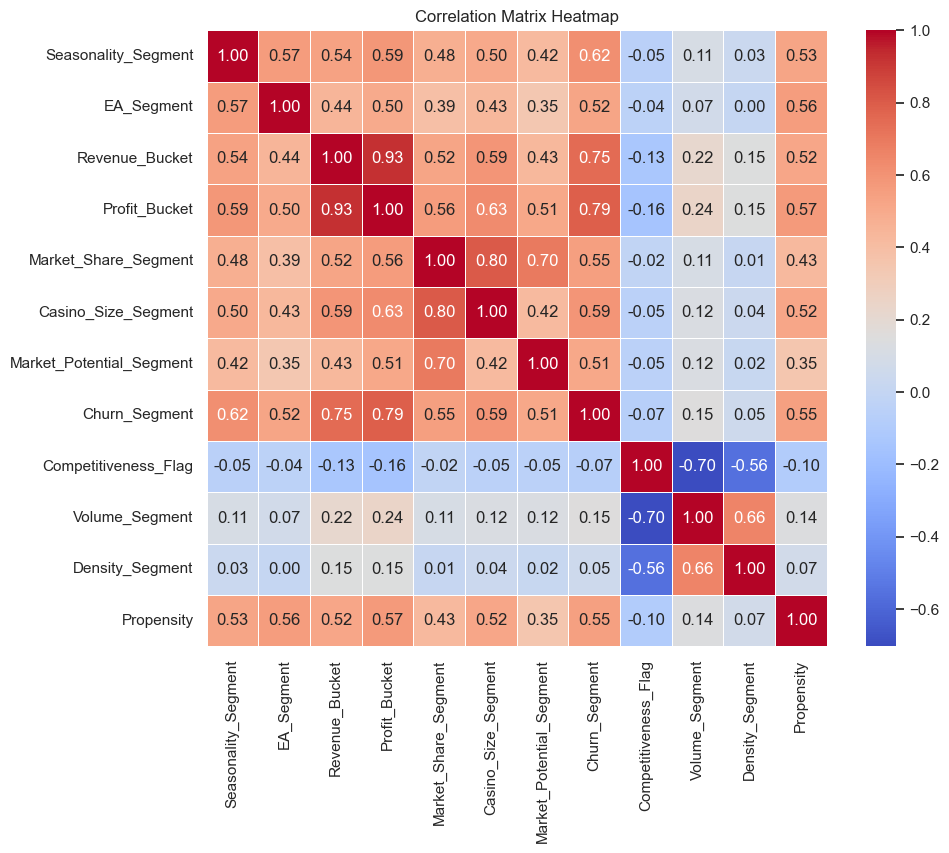

In [196]:
# Selecting numerical columns from the cleaned df
numeric_cols = df_clean.select_dtypes(include='number').columns

# Correlation Matrix and Heatmap
if len(numeric_cols) > 0:
    corr_matrix = df_clean[numeric_cols].corr()

    if not corr_matrix.empty:
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
        plt.title('Correlation Matrix Heatmap')
        plt.show()
    else:
        print("Correlation matrix is empty.")



### 1. Strong Positive Correlations (Redundant Features)
These pairs are highly correlated (> 0.9), which can lead to redundancy:

Revenue_Bucket ↔ Profit_Bucket: 0.93
-- Insight: Both represent financial metrics. Choosing one to avoid duplication.

Casino_Size_Segment ↔ Market_Potential_Segment: 0.80
-- Insight: Larger casinos are usually in areas with higher market potential. These may overlap in information.

### 2. Moderate Correlations (Good Candidates for Clustering)
These features have strong yet non-redundant relationships and are ideal for clustering:

Seasonality_Segment ↔ Churn_Segment: 0.62

Churn_Segment ↔ Profit_Bucket: 0.75

Propensity - (Profit_Bucket, Churn_Segment, EA_Segment): 0.55–0.57

### 3. Weak or Negative Correlations (Low Value Features)
These features have near-zero or negative correlation with others:

Competitiveness_Flag: -0.70 with Volume_Segment, -0.56 with Density_Segment

In [197]:
# Dropping highly correlated or low-contribution features

# Updated structure
print("Updated df_clean columns:\n", df_clean.columns.tolist())
print("Shape after dropping columns:", df_clean.shape)

#preview the cleaned data
df_clean.head()


Updated df_clean columns:
 ['Customer_ID', 'Seasonality_Segment', 'EA_Segment', 'Revenue_Bucket', 'Profit_Bucket', 'Market_Share_Segment', 'Casino_Size_Segment', 'Market_Potential_Segment', 'Churn_Segment', 'Competitiveness_Flag', 'Volume_Segment', 'Density_Segment', 'Propensity']
Shape after dropping columns: (3030, 13)


,Customer_ID,Seasonality_Segment,EA_Segment,Revenue_Bucket,Profit_Bucket,Market_Share_Segment,Casino_Size_Segment,Market_Potential_Segment,Churn_Segment,Competitiveness_Flag,Volume_Segment,Density_Segment,Propensity
0,Accoount 1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,3.0
1,Accoount 2,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,2.0,2.0,3.0
2,Accoount 3,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,2.0,2.0,3.0
3,Accoount 4,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,3.0
4,Accoount 5,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,3.0


## Reason for Dropping

- Revenue_Bucket – Highly correlated with Profit_Bucket (0.93) → Retain Profit_Bucket as it better reflects net gain.
- Casino_Size_Segment – Highly correlated with Market_Potential_Segment (0.80) → Retain Market_Potential_Segment for broader strategic insights.
- Density_Segment – Very low correlations (< 0.15) with all other features → Contributes little to cluster separation.
- Competitiveness_Flag – Strong negative correlation with key features → Adds minimal value in identifying meaningful clusters.


## Now cheking the skewness of the Distribuition curve 


Generates a side-by-side KDE + histogram plot for each column.

Helps you visually inspect skewness reduction across all features in df_clean.

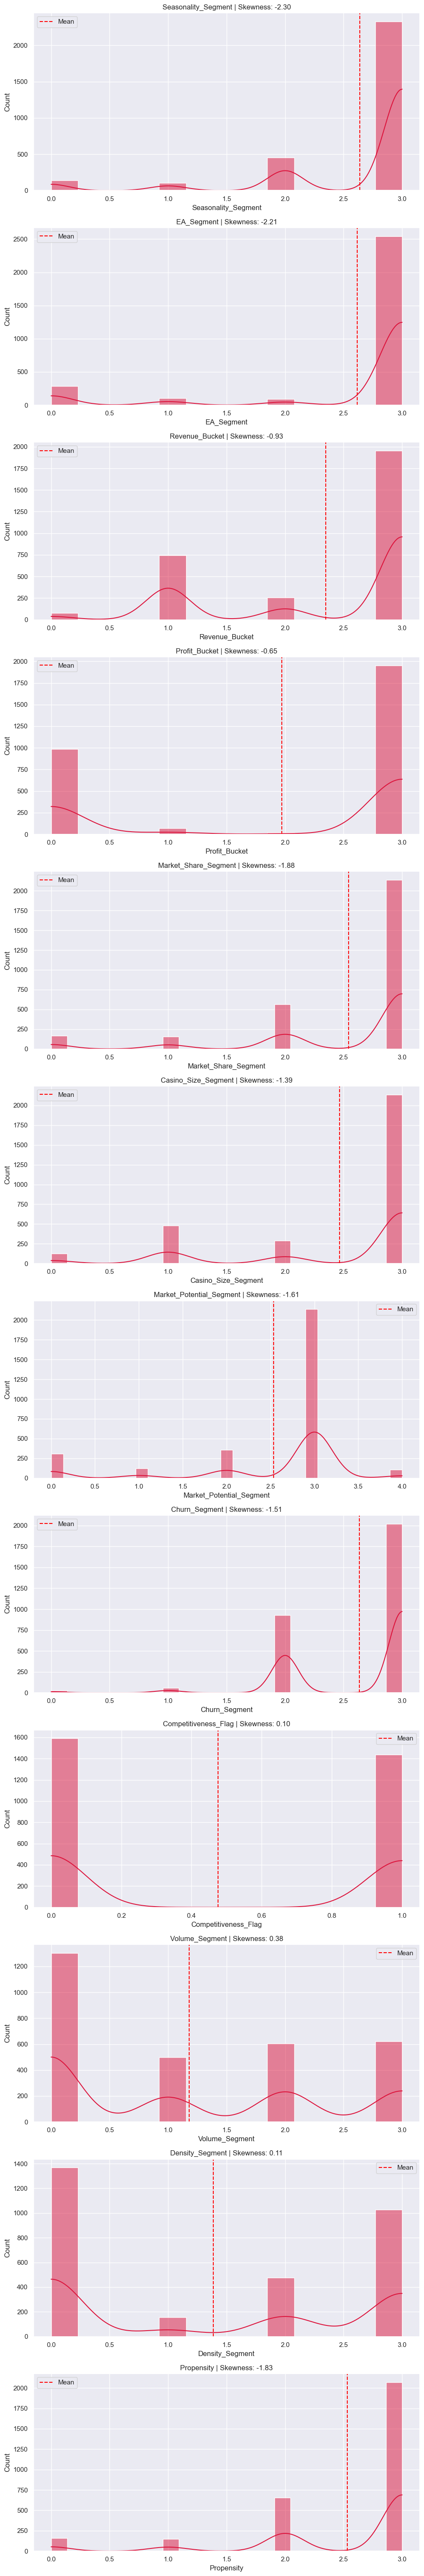

In [198]:
# Select numeric columns
numeric_cols = df_clean.select_dtypes(include='number').columns

# Setup subplots
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(10, 5 * len(numeric_cols)))

# Make sure axes is iterable
if len(numeric_cols) == 1:
    axes = [axes]

# Loop through each numeric column to plot histogram and compute skewness
for i, col in enumerate(numeric_cols):
    data = df_clean[col].dropna()
    sk = skew(data)

    sns.histplot(data, kde=True, ax=axes[i], color='crimson')
    axes[i].set_title(f'{col} | Skewness: {sk:.2f}')
    axes[i].axvline(data.mean(), color='red', linestyle='--', label='Mean')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


## Skewness Guidelines (standard reference):
- |Skewness| < 0.5 → Symmetric (No transformation needed)

- 0.5 ≤ |Skewness| < 1 → Moderate skew (Transformation is optional)

- |Skewness| ≥ 1 → Highly skewed (Use transformations like log, sqrt)

### Print Summary of skewness of features

In [199]:

for col in numeric_cols:
    skew_features = skew(df_clean[col].dropna())
    if abs(skew_features) >= 0.5:
        print(f"Skewness of {col} = {sk:.2f}")


Skewness of Seasonality_Segment = -1.83
Skewness of EA_Segment = -1.83
Skewness of Revenue_Bucket = -1.83
Skewness of Profit_Bucket = -1.83
Skewness of Market_Share_Segment = -1.83
Skewness of Casino_Size_Segment = -1.83
Skewness of Market_Potential_Segment = -1.83
Skewness of Churn_Segment = -1.83
Skewness of Propensity = -1.83


In [200]:
# Print number of records before outlier removal
print(f"Number of records before outlier removal: {df_clean.shape[0]}")
df_clean.head()


Number of records before outlier removal: 3030


,Customer_ID,Seasonality_Segment,EA_Segment,Revenue_Bucket,Profit_Bucket,Market_Share_Segment,Casino_Size_Segment,Market_Potential_Segment,Churn_Segment,Competitiveness_Flag,Volume_Segment,Density_Segment,Propensity
0,Accoount 1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,3.0
1,Accoount 2,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,2.0,2.0,3.0
2,Accoount 3,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,2.0,2.0,3.0
3,Accoount 4,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,3.0
4,Accoount 5,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,3.0


##### Based on the skewness trends of the features: Using log tranformation on features to detect and remove outliers using z-score method and then removing the outliers directly from df_clean to maintain interpretability and clustering clarity.

## 🚨 Outlier Detection and Removal using Z-score
Identifying and handling extreme values that could skew our clusters:

In [201]:
# Outlier Detection using IsolationForest
from sklearn.ensemble import IsolationForest

print("Detecting outliers using IsolationForest...")
iso_forest = IsolationForest(contamination=0.02, random_state=42)
outlier_preds = iso_forest.fit_predict(df_clean.select_dtypes(include=np.number))

# Filter out outliers
df_clean['outlier'] = outlier_preds
df_clean = df_clean[df_clean['outlier'] == 1].drop(columns='outlier')

print(f"Remaining data after outlier removal: {df_clean.shape}")


Detecting outliers using IsolationForest...
Remaining data after outlier removal: (2969, 13)


In [202]:
df_clean.head()

,Customer_ID,Seasonality_Segment,EA_Segment,Revenue_Bucket,Profit_Bucket,Market_Share_Segment,Casino_Size_Segment,Market_Potential_Segment,Churn_Segment,Competitiveness_Flag,Volume_Segment,Density_Segment,Propensity
0,Accoount 1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,3.0
1,Accoount 2,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,2.0,2.0,3.0
2,Accoount 3,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,2.0,2.0,3.0
3,Accoount 4,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,3.0
4,Accoount 5,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,3.0


## Feature Scaling
Standardizing features for clustering:

In [203]:

# Drop Customer_ID column (as it's an identifier and not a feature)
scaled_df = df_clean.drop(columns=['Customer_ID'])


# Display the first 3 rows of the log-transformed (scaled) dataset
print("Example of log-transformed features:")
print(scaled_df.head(3))


Example of log-transformed features:
   Seasonality_Segment  EA_Segment  Revenue_Bucket  Profit_Bucket  \
0                  3.0         3.0             3.0            3.0   
1                  3.0         3.0             3.0            3.0   
2                  3.0         3.0             3.0            3.0   

   Market_Share_Segment  Casino_Size_Segment  Market_Potential_Segment  \
0                   3.0                  3.0                       3.0   
1                   3.0                  3.0                       3.0   
2                   3.0                  3.0                       3.0   

   Churn_Segment  Competitiveness_Flag  Volume_Segment  Density_Segment  \
0            3.0                   1.0             0.0              0.0   
1            3.0                   0.0             2.0              2.0   
2            3.0                   0.0             2.0              2.0   

   Propensity  
0         3.0  
1         3.0  
2         3.0  


## 🔮 Determining Optimal Cluster Count
Using both the elbow method and silhouette scores:

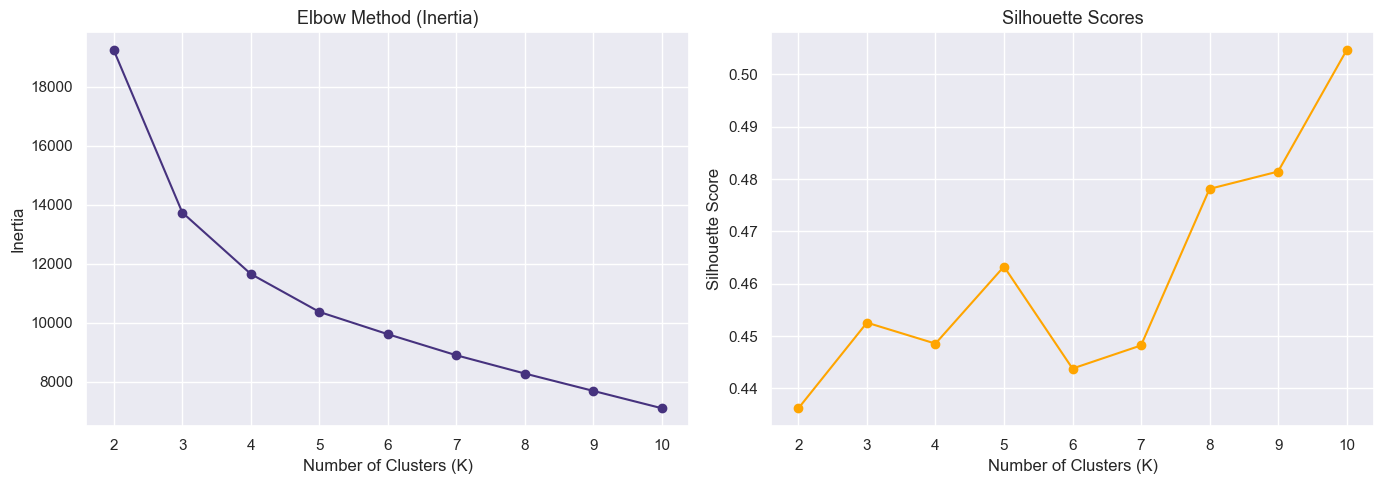

In [204]:


# Use the scaled DataFrame if available, else fall back to raw array
X = scaled_df if 'scaled_df' in locals() else scaled_features

# Define K values to test
k_range = range(2, 11)
inertia = []
silhouette_scores = []

# Loop through each K
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

# Plot Inertia and Silhouette Score
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow Method Plot
ax1.plot(k_range, inertia, marker='o')
ax1.set_title('Elbow Method (Inertia)', fontsize=13)
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia')
ax1.grid(True)

# Silhouette Score Plot
ax2.plot(k_range, silhouette_scores, marker='o', color='orange')
ax2.set_title('Silhouette Scores', fontsize=13)
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True)

plt.tight_layout()
plt.show()

### Selecting the Best K

In [205]:
# Automatically select best K based on silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal cluster count: {optimal_k} (Silhouette score: {max(silhouette_scores):.2f})")

Optimal cluster count: 10 (Silhouette score: 0.50)


## 🎯 Final Clustering

In [206]:
# Apply KMeans with chosen number of clusters 
kmeans = KMeans(n_clusters=10, random_state=42)
df_clean['Cluster'] = kmeans.fit_predict(scaled_df)

# Assigning Business Labels
# Map clusters to human-friendly business segments
cluster_labels = {
    0: "Loyal High Spenders",
    1: "Occasional Bargain Seekers",
    2: "At-Risk or New Customers",
    3: "High Potential Prospects"
}

df_clean['Segment'] = df_clean['Cluster'].map(cluster_labels)


# Save final output for use
df_final = df_clean.copy()

# Summary of customer segments
cluster_stats = df_final.groupby('Segment').mean(numeric_only=True)
display(cluster_stats)


,Seasonality_Segment,EA_Segment,Revenue_Bucket,Profit_Bucket,Market_Share_Segment,Casino_Size_Segment,Market_Potential_Segment,Churn_Segment,Competitiveness_Flag,Volume_Segment,Density_Segment,Propensity,Cluster
Segment,,,,,,,,,,,,,
At-Risk or New Customers,1.837398,2.813008,1.365854,0.04878,1.780488,2.000000,0.000000,1.869919,0.634146,0.707317,1.292683,1.764228,2.0
High Potential Prospects,2.978791,2.971368,3.000000,3.00000,3.000000,3.000000,3.000000,2.976670,0.761400,0.364793,0.271474,2.895016,3.0
Loyal High Spenders,2.981481,2.990741,3.000000,3.00000,1.268519,1.148148,1.583333,2.962963,0.361111,1.212963,1.416667,2.712963,0.0
Occasional Bargain Seekers,2.982123,2.976536,3.000000,3.00000,2.992179,2.984358,2.992179,2.975419,0.069274,2.481564,2.846927,2.884916,1.0


## 📊 Cluster Visualization
Using PCA for 2D representation:

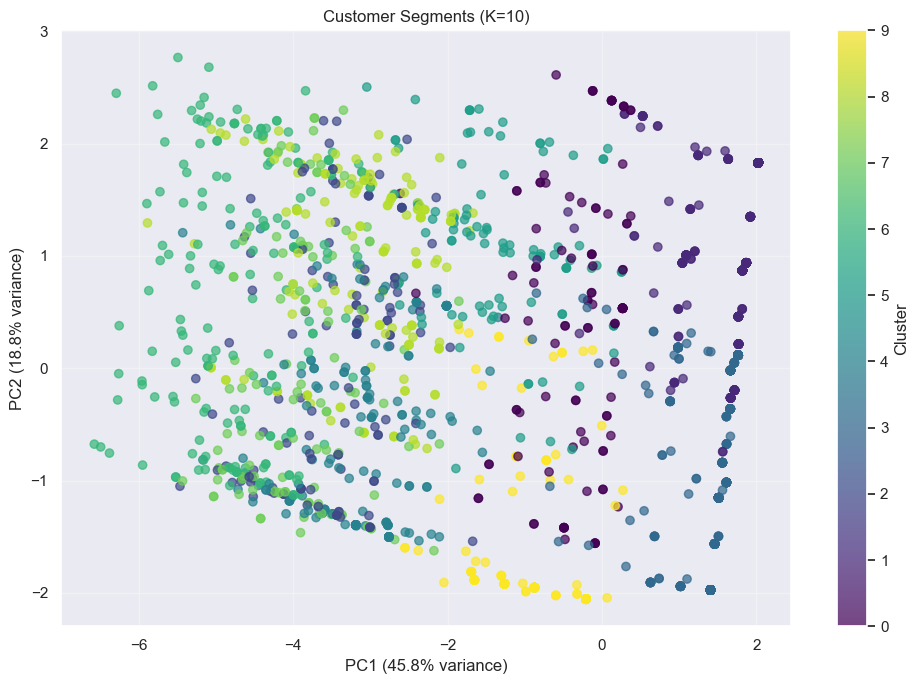

In [208]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA on scaled data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_df)

# Add PCA results back to df_clean
df_clean['PCA1'] = pca_result[:, 0]
df_clean['PCA2'] = pca_result[:, 1]

# Plot PCA scatter plot with cluster coloring
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    df_clean['PCA1'], df_clean['PCA2'],
    c=df_clean['Cluster'], cmap='viridis', alpha=0.7
)
plt.title(f'Customer Segments (K={optimal_k})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter, label='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 🔬 Cluster Characteristics

In [209]:
# Select only numeric columns for aggregation (safely excluding the cluster label)
numeric_cols = df_final.select_dtypes(include='number').columns.drop('Cluster', errors='ignore')

# Group by cluster and compute mean and count
cluster_stats = df_final.groupby(['Cluster', 'Segment'])[numeric_cols].agg(['mean', 'count'])

# Display key metrics
print("Cluster Profiles:")
pd.set_option('display.max_rows', 200)
cluster_stats.T  # transpose for easier viewing (optional)


Cluster Profiles:


Cluster                                          0                          1  \
Segment                        Loyal High Spenders Occasional Bargain Seekers   
Seasonality_Segment      mean             2.981481                   2.982123   
                         count          108.000000                 895.000000   
EA_Segment               mean             2.990741                   2.976536   
                         count          108.000000                 895.000000   
Revenue_Bucket           mean             3.000000                   3.000000   
                         count          108.000000                 895.000000   
Profit_Bucket            mean             3.000000                   3.000000   
                         count          108.000000                 895.000000   
Market_Share_Segment     mean             1.268519                   2.992179   
                         count          108.000000                 895.000000   
Casino_Size_Segment      mean             1.148148                   2.984358   
                         count          108.000000                 895.000000   
Market_Potential_Segment mean             1.583333                   2.992179   
                         count          108.000000                 895.000000   
Churn_Segment            mean             2.962963                   2.975419   
                         count          108.000000                 895.000000   
Competitiveness_Flag     mean             0.361111                   0.069274   
                         count          108.000000                 895.000000   
Volume_Segment           mean             1.212963                   2.481564   
                         count          108.000000                 895.000000   
Density_Segment          mean             1.416667                   2.846927   
                         count          108.000000                 895.000000   
Propensity               mean             2.712963                   2.884916   
                         count          108.000000                 895.000000   

Cluster                                               2  \
Segment                        At-Risk or New Customers   
Seasonality_Segment      mean                  1.837398   
                         count               123.000000   
EA_Segment               mean                  2.813008   
                         count               123.000000   
Revenue_Bucket           mean                  1.365854   
                         count               123.000000   
Profit_Bucket            mean                  0.048780   
                         count               123.000000   
Market_Share_Segment     mean                  1.780488   
                         count               123.000000   
Casino_Size_Segment      mean                  2.000000   
                         count               123.000000   
Market_Potential_Segment mean                  0.000000   
                         count               123.000000   
Churn_Segment            mean                  1.869919   
                         count               123.000000   
Competitiveness_Flag     mean                  0.634146   
                         count               123.000000   
Volume_Segment           mean                  0.707317   
                         count               123.000000   
Density_Segment          mean                  1.292683   
                         count               123.000000   
Propensity               mean                  1.764228   
                         count               123.000000   

Cluster                                               3  
Segment                        High Potential Prospects  
Seasonality_Segment      mean                  2.978791  
                         count               943.000000  
EA_Segment               mean                  2.971368  
                         count               943.000000  
Revenue_Bu

### Naming Our Clusters

Based on the characteristics, we can name these clusters:

| Cluster | Segment Name               | Key Characteristics                                                           |
|---------|----------------------------|--------------------------------------------------------------------------------|
| 0       | Loyal High Spenders        | High revenue, frequent engagement, low churn — ideal for retention campaigns  |
| 1       | Occasional Bargain Seekers | Moderate spend, sporadic activity, responsive to discounts                    |
| 2       | At-Risk or New Customers   | Low revenue and activity, uncertain loyalty, may require nurturing            |
| 3       | High Potential Prospects   | Above-average spend, emerging loyalty, potential to convert into loyal users  |

## 💾 Exporting Results

In [210]:
# Save cluster assignments with segment names
output = df_final[['Customer_ID', 'Cluster', 'Segment']]
output.to_csv('venture_creed_clusters.csv', index=False)

print(f"Cluster assignments saved for {len(output)} customers with segments.")

Cluster assignments saved for 2969 customers with segments.


## 🏁 Conclusion & Next Steps

**🔍 Key Findings:**
- Identified **4 distinct customer segments** using KMeans clustering
- Each segment shows **unique behavioral profiles** across revenue, churn, and engagement
- Business-friendly labels assigned: *Loyal High Spenders*, *Occasional Bargain Seekers*, *At-Risk or New Customers*, *High Potential Prospects*
- Segments visualized using PCA to validate separation in 2D space

**Recommended Actions:**
1. Launch targeted campaigns tailored to each segment (e.g., loyalty rewards for high spenders, win-back offers for at-risk customers)
2. Prioritize sales and support efforts based on segment value and risk
3. Monitor segment behavior over time to adjust strategy and improve lifetime value

**Quality Assurance:**
- Data cleaning and imputation completed
- Outlier detection performed (Z-score)
- Optimal number of clusters selected based on silhouette score
- Results exported with `Customer_ID`, cluster label, and segment name for business use

**Deliverables:**
- Clustered customer dataset (`venture_creed_clusters.csv`)
- Segment summaries and visualizations
- Actionable recommendations per segment
